In [24]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import FeatureAblation

%matplotlib inline

In [25]:
model = torch.load('weights/classifier.pth')
model.eval()
torch.manual_seed(123)
np.random.seed(123)

In [32]:
transform = transforms.Compose([
 transforms.Resize((256, 256)),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

pic_name = '003994e.jpg'

img = Image.open(f'data/train_images/{pic_name}')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0).to('cuda:0')
output = model(input)
idx_to_labels = ['flower', 'gravel', 'sugar', 'fish']
output = F.softmax(output, dim=1)

df = pd.read_csv('data/train.csv')

df['image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
df['label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])
df

,Image_Label,EncodedPixels,image,label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
6,002be4f.jpg_Gravel,NaN,002be4f.jpg,Gravel
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,0031ae9.jpg,Fish
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,0031ae9.jpg,Flower


In [33]:
list_of_correct_labels = [cl.lower() for cl in df[df['image'] == pic_name].dropna()['label'].tolist()]

def rle_to_mask(rle_string, width = 2100, height = 1400):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype= bool)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def get_occlusions_integrated_gradients(img, encoded_pixel, class_label):
    mask = np.array((rle_to_mask(encoded_pixel, 2100, 1400) * 1)).T
    mask = np.where(mask > 0, 1, 0)
    lbl = label(mask)
    props = regionprops(lbl)
    props_list = [prop for prop in props if prop.area > 60000]
    integrated_gradients = IntegratedGradients(model)
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input,
                                           strides = (3, 15, 15),
                                           target=['flower', 'gravel', 'sugar', 'fish'].index(class_label),
                                           sliding_window_shapes=(3,15, 15),
                                           baselines=0)
    attributions_ig = integrated_gradients.attribute(input, target=['flower', 'gravel', 'sugar', 'fish'].index(class_label), n_steps=5)
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    fig, axs = plt.subplots(1,figsize=(15,15), ncols = 3)
    fig, axs[0] = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1, 
                                 plt_fig_axis = (fig, axs[0]), 
                                 use_pyplot = False)
    fig, axs[1] = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1, 
                                 plt_fig_axis = (fig, axs[1]), 
                                 use_pyplot = False)
    axs[2].imshow(transformed_img.detach().cpu().numpy().transpose((1, 2, 0)))
    scale = np.flipud(np.divide((256, 256), (1400, 2100)))
    colors = ['blue','blue','white']
    for ax_idx, ax in enumerate(axs):
        for prop in props_list:
            ax.add_patch(mpl.patches.Rectangle((prop.bbox[0] * scale[0], prop.bbox[1] * scale[1]),
                                               prop.bbox[2] * scale[0] - prop.bbox[0] * scale[0],
                                               prop.bbox[3] * scale[1] - prop.bbox[1] * scale[1],
                                               linewidth= 3,
                                               edgecolor= colors[ax_idx],
                                               facecolor='none'))
    
    axs[0].set_title(f'Integrated Gradients Plot, ({class_label})')
    axs[1].set_title(f'OcclusionSensitivity Map, ({class_label})')
    axs[2].set_title(f'Original Image, ({class_label})')
    plt.show()

Predicted: fish :( 0.24202533066272736 )


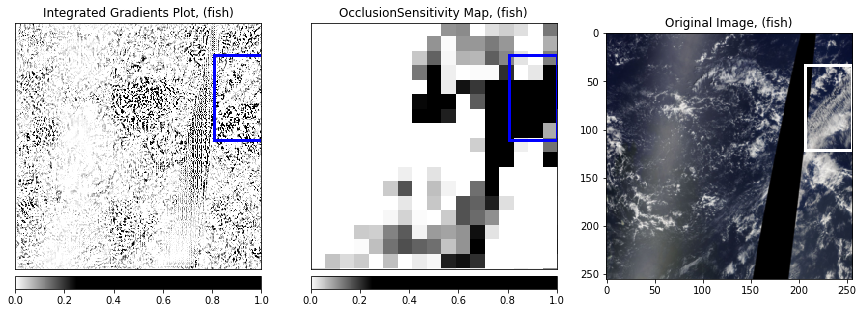

Predicted: gravel :( 0.2514078617095947 )


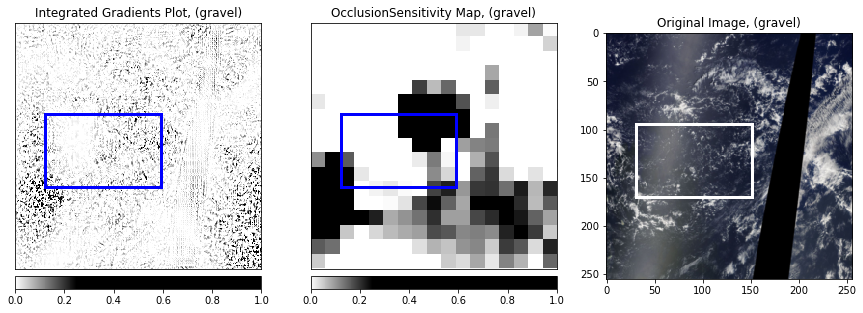

Predicted: sugar :( 0.27962028980255127 )


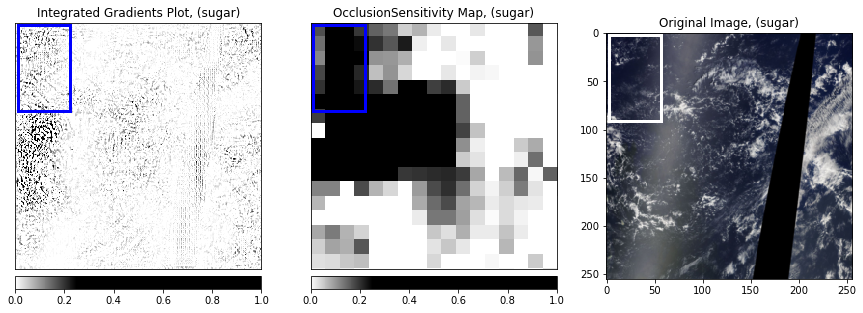

In [34]:
for label1 in list_of_correct_labels:
    prediction_score, pred_label_idx = torch.topk(output, 4)
    pred_label_idx.squeeze_()
    print('Predicted:', label1, ':(', prediction_score.squeeze()[pred_label_idx.tolist().index(['flower', 'gravel', 'sugar', 'fish'].index(label1))].item(), ')')
    encoded_pixel_sugar = df[(df['image'] == pic_name) & (df['label'] == label1.capitalize())]['EncodedPixels'].values[0]
    get_occlusions_integrated_gradients(img, encoded_pixel_sugar, label1)